# Prepare data

In [59]:
# Import Stuff
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer, HashingVectorizer, CountVectorizer
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, ConfusionMatrixDisplay

from hpsklearn import HyperoptEstimator

In [63]:
pheme = pd.read_csv('datasets\pheme.csv')
politifact = pd.read_csv('datasets\politifact.csv')
twitter = pd.read_csv('datasets\\twitter.csv')

In [64]:
x = pheme['text']
y = pheme['target']

In [18]:
max = 0
for text in pheme['text']:
    if len(text) > max:
        max = len(text)
max

149

In [77]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from tqdm import tqdm

token = Tokenizer()
token.fit_on_texts(x)
seq = token.texts_to_sequences(x)
pad_seq = pad_sequences(seq,maxlen=300)
vocab_size = len(token.word_index)+1

embedding_vector = {}
f = open('glove\glove.twitter.27B.200d.txt')
for line in tqdm(f):
    value = line.split(' ')
    word = value[0]
    coef = np.array(value[1:],dtype = 'float32')
    embedding_vector[word] = coef

embedding_matrix = np.zeros((vocab_size,200))
hits=0
misses=0
for word,i in tqdm(token.word_index.items()):
    embedding_value = embedding_vector.get(word)
    if embedding_value is not None:
        embedding_matrix[i] = embedding_value
        hits +=1
    else:
        misses += 1
print(f"Converted {hits} words and {misses} misses")

1193514it [01:05, 18212.35it/s]
100%|██████████| 3839/3839 [00:00<00:00, 426597.78it/s]

Converted 3456 words and 383 misses


In [79]:
from transformers import AutoTokenizer, TFAutoModelForSequenceClassification, DataCollatorWithPadding

tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")
data_collator = DataCollatorWithPadding(tokenizer=tokenizer, return_tensors="tf")

def preprocess_function(examples):
    return tokenizer(examples["text"], truncation=True)

id2label = {0: "False", 1: "True"}
label2id = {"False": 0, "True": 1}

model = TFAutoModelForSequenceClassification.from_pretrained(
    "distilbert-base-uncased", num_labels=2, id2label=id2label, label2id=label2id
)

tf_train_set = model.prepare_tf_dataset(
    pheme['text'],
    shuffle=True,
    batch_size=16,
    collate_fn=data_collator,
)


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_layer_norm.weight', 'vocab_transform.weight', 'vocab_layer_norm.bias', 'vocab_transform.bias', 'vocab_projector.bias']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFDistilBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier.weight', 'classifier.bias']
You should 

NameError: name 'data_collator' is not defined

In [ ]:
from zeugma.embeddings import EmbeddingTransformer

glove = EmbeddingTransformer('glove')


In [5]:
def encode_two_datasets(set1, set2):
    tfidf = TfidfVectorizer(max_df=0.6, min_df=0)
    all_statements = np.append(set1, set2)
    all_tf = tfidf.fit_transform(all_statements)
    return all_tf[:len(set1)], all_tf[len(set1):]

In [8]:
rs = 42
method = 3
tfidf = TfidfVectorizer(max_df=0.6, min_df=0)
#tfidf = CountVectorizer(max_df=0.6, min_df=0)

if method == 0:
    pheme_tf = tfidf.fit_transform(pheme['text'].values)
    X_train, X_test, y_train, y_test = train_test_split(pheme_tf, pheme['target'], test_size = 0.25, random_state = rs)
elif method == 1:
    polit_tf = tfidf.fit_transform(politifact['statement'].values)
    X_train, X_test, y_train, y_test = train_test_split(polit_tf, politifact['verdict'], test_size = 0.25, random_state = rs)
elif method == 2:
    twitter_tf = tfidf.fit_transform(twitter['text'].values)
    X_train, X_test, y_train, y_test = train_test_split(twitter_tf, twitter['verdict'], test_size = 0.25, random_state = rs)
elif method == 3:
    X_train, X_test = encode_two_datasets(twitter['text'].values, pheme['text'].values)
    y_test = pheme['target']
    y_train = twitter['verdict']
else:
    X_train, X_test = encode_two_datasets(politifact['statement'].values, pheme['text'].values)
    y_train = politifact['verdict']
    y_test = pheme['target']
    

# Set no. of folds
num_folds = 10

###Things to do: add more features
print(X_train.shape)

(1729, 6101)


# Run models

In [7]:
# Model running function
def run_model_after_gridsearch(best_estimators, X_train, y_train, X_test, y_test):
    mod = best_estimators
    mod.fit(X_train, y_train)
    pred_y = mod.predict(X_test)
    acc_mod = accuracy_score(y_test, pred_y)
    print("Accuracy:", float("{0:.2f}".format(acc_mod*100)), "%")
    f1_mod = f1_score(y_test, pred_y, average="macro")
    print("F1:", float("{0:.2f}".format(f1_mod*100)), "%")
    cm = confusion_matrix(y_test, pred_y)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["true", "false"])
    disp.plot()
    plt.show()  

In [8]:
def run_model_manually(model, X_test, y_test):
    pred_y = model.predict(X_test)
    acc_mod = accuracy_score(y_test, pred_y)
    print("Accuracy:", float("{0:.2f}".format(acc_mod*100)), "%")
    f1_mod = f1_score(y_test, pred_y, average="macro")
    print("F1:", float("{0:.2f}".format(f1_mod*100)), "%")
    cm = confusion_matrix(y_test, pred_y)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["true", "false"])
    disp.plot()
    plt.show() 

In [9]:
def optimize_model(model, X_train, y_train):
    mod = HyperoptEstimator(classifier=model,
                            preprocessing=[],
                            max_evals=50)
    mod.fit(X_train, y_train)
    print(mod.best_model())
    return mod

def evaluate_model(model, X_test, y_test):
    pred_y = model.predict(X_test)
    acc_mod = accuracy_score(y_test, pred_y)
    print("Accuracy:", float("{0:.2f}".format(acc_mod*100)), "%")
    f1_mod = f1_score(y_test, pred_y, average="macro")
    print("F1:", float("{0:.2f}".format(f1_mod*100)), "%")
    cm = confusion_matrix(y_test, pred_y)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["true", "false"])
    disp.plot()
    plt.show() 
    

In [52]:
# SVM
from hpsklearn import svc 
svm = optimize_model(svc("mySVC", probability=True), X_train, y_train)

100%|██████████| 50/50 [00:02<00:00,  2.68s/trial, best loss: 0.1502890173410405]
{'learner': SVC(C=1.3845598371558152, coef0=0.664697472814461, gamma='auto',
    kernel='linear', probability=True, random_state=4, shrinking=False,
    tol=0.0014164342905822872), 'preprocs': (), 'ex_preprocs': ()}


Accuracy: 75.19 %
F1: 75.14 %


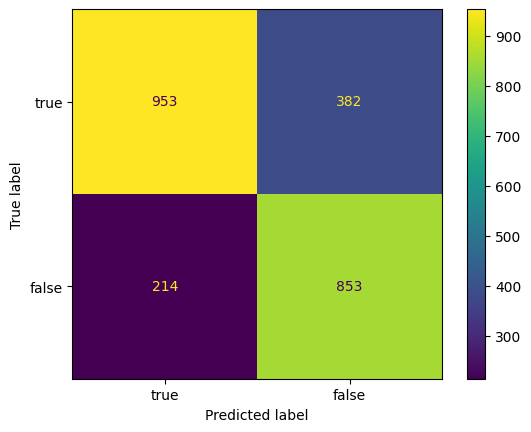

In [53]:
evaluate_model(svm, X_test, y_test)

In [13]:
# KNN
from hpsklearn import k_neighbors_classifier
from hyperopt import hp
knn_metrics = hp.choice("metric", {'cityblock', 'l1', 'l2', 'euclidean', 'manhattan'})
knn= optimize_model(k_neighbors_classifier("myKNN", metric=knn_metrics), X_train, y_train)

100%|██████████| 50/50 [00:01<00:00,  1.62s/trial, best loss: 0.12716763005780352]
{'learner': KNeighborsClassifier(leaf_size=24, metric='euclidean', n_jobs=1, n_neighbors=1,
                     p=3.4894408296300257), 'preprocs': (), 'ex_preprocs': ()}


Accuracy: 70.61 %
F1: 70.52 %


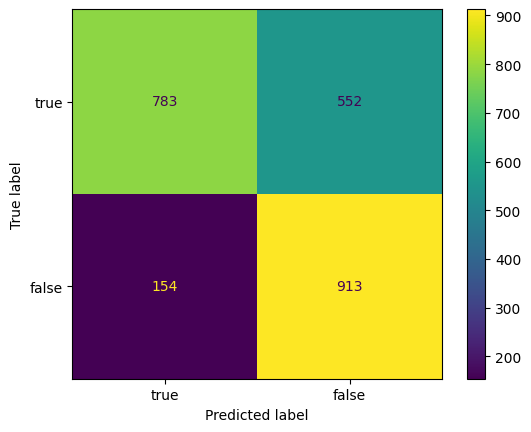

In [14]:
evaluate_model(knn, X_test, y_test)

In [15]:
# Logistic Regression logistic_regression
from hpsklearn import logistic_regression
myLR = optimize_model(logistic_regression("myLR"), X_train, y_train)

100%|██████████| 50/50 [00:01<00:00,  1.57s/trial, best loss: 0.20231213872832365]
{'learner': LogisticRegression(C=1.8638068202455687, max_iter=427, n_jobs=1, random_state=3,
                   solver='sag', tol=1.4973841902398913e-05), 'preprocs': (), 'ex_preprocs': ()}


Accuracy: 73.48 %
F1: 72.91 %


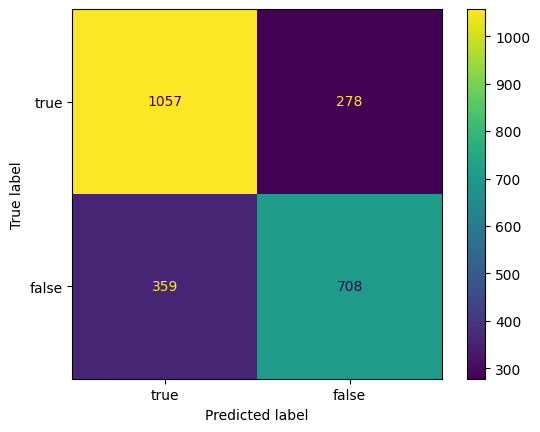

In [16]:
evaluate_model(myLR, X_test, y_test)

In [17]:
# AdaBoost
from hpsklearn import ada_boost_classifier, decision_tree_classifier
baseDT = decision_tree_classifier("adaDT")
ada = optimize_model(ada_boost_classifier("myada", base_estimator=baseDT), X_train, y_train)

100%|██████████| 50/50 [00:01<00:00,  1.60s/trial, best loss: 0.13005780346820806]


c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\ensemble\_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


{'learner': AdaBoostClassifier(algorithm='SAMME',
                   base_estimator=DecisionTreeClassifier(criterion='entropy',
                                                         max_features=0.9628355028815264,
                                                         random_state=2),
                   learning_rate=0.0010359022650509517, n_estimators=14,
                   random_state=4), 'preprocs': (), 'ex_preprocs': ()}


Accuracy: 71.98 %
F1: 71.94 %


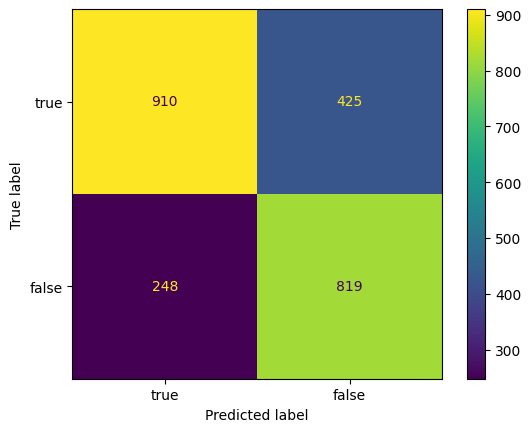

In [18]:
# Run model with best results
evaluate_model(ada, X_test, y_test)

In [19]:
from hpsklearn import mlp_classifier

mlp = optimize_model(mlp_classifier("mlp"), X_train, y_train)

100%|██████████| 50/50 [00:04<00:00,  4.27s/trial, best loss: 0.13005780346820806]
{'learner': MLPClassifier(activation='tanh', alpha=0.00010298894903304274,
              beta_1=0.9280085351055765, beta_2=0.9895237835858289,
              epsilon=1.4169790985721152e-06, learning_rate='invscaling',
              learning_rate_init=0.0010906433814813626, max_fun=16362,
              max_iter=293, momentum=0.9616724790980509,
              power_t=0.2326735382514724, random_state=1,
              tol=0.001464409080319833,
              validation_fraction=0.17722740329954012), 'preprocs': (), 'ex_preprocs': ()}


Accuracy: 74.19 %
F1: 74.13 %


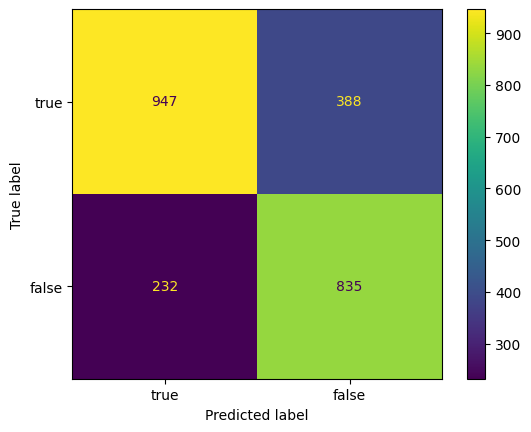

In [20]:
evaluate_model(mlp, X_test, y_test)

# Clustering

In [58]:
from sklearn.mixture import GaussianMixture

gm = GaussianMixture().fit(X_train)
gm.means_


TypeError: A sparse matrix was passed, but dense data is required. Use X.toarray() to convert to a dense numpy array.

## Ensemble

In [54]:
sk_svm = svm.best_model()['learner']
sk_knn = knn.best_model()['learner']
sk_LR = myLR.best_model()['learner']
sk_ada = ada.best_model()['learner']
sk_mlp = mlp.best_model()['learner']

c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\ensemble\_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Accuracy: 76.19 %
F1: 76.12 %


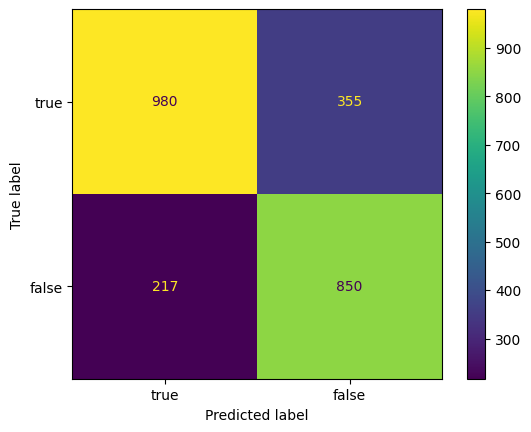

In [55]:
# Hard voting
from sklearn.ensemble import VotingClassifier

sk_classifiers = [sk_svm, sk_knn, sk_LR, sk_ada, sk_mlp]
names = ["svm", "knn", "LR", "ada", "mlp"]

hardvoter = VotingClassifier(estimators=list(zip(names, sk_classifiers)), voting="hard")
hardvoter.fit(X_train, y_train)
evaluate_model(hardvoter, X_test, y_test)

c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\ensemble\_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Accuracy: 75.6 %
F1: 75.59 %


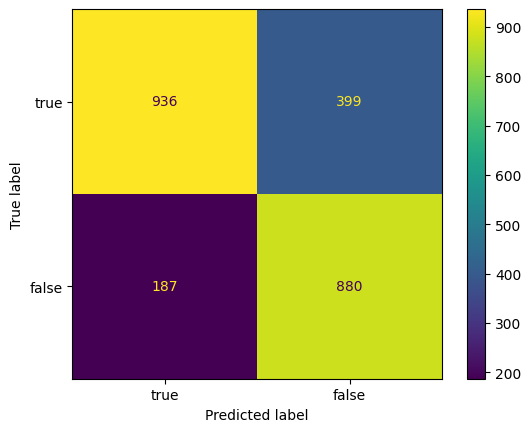

In [56]:
softvoter = VotingClassifier(estimators=list(zip(names, sk_classifiers)), voting="soft")
softvoter.fit(X_train, y_train)
evaluate_model(softvoter, X_test, y_test)

In [33]:
from deslib.des import KNORAE

classifiers = [svm, knn, myLR, ada, mlp]

for c in classifiers:
    c.fit(X_train.toarray(), y_train)
    
for c in classifiers:
    print(c.best_model())


100%|██████████| 50/50 [00:02<00:00,  2.12s/trial, best loss: 0.12138728323699421]


c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\ensemble\_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


100%|██████████| 50/50 [00:05<00:00,  5.59s/trial, best loss: 0.11271676300578037]
{'learner': SVC(C=1.3859124309792619, coef0=0.12068536714031086, degree=1, kernel='linear',
    random_state=2, tol=0.00021015619572883426), 'preprocs': (), 'ex_preprocs': ()}
{'learner': KNeighborsClassifier(leaf_size=33, metric='l2', n_jobs=1, n_neighbors=1,
                     p=4.675960977330624, weights='distance'), 'preprocs': (), 'ex_preprocs': ()}
{'learner': LogisticRegression(C=1.892356880560552, max_iter=455, n_jobs=1, random_state=1,
                   solver='sag', tol=0.00035719537044419836), 'preprocs': (), 'ex_preprocs': ()}
{'learner': AdaBoostClassifier(base_estimator=DecisionTreeClassifier(criterion='entropy',
                                                         max_features=0.39609196963056637,
                                                         random_state=3),
                   learning_rate=0.004615493166759093, n_estimators=73,
                   random_state=3), 'prepr

In [34]:
hp_classifiers = [svm, knn, myLR, ada, mlp]

sk_classifiers = []

for c in classifiers:
    sk_model = c.best_model()['learner']
    sk_model.fit(X_train.toarray(), y_train)
    sk_classifiers.append(sk_model)


c:\Users\willc\miniconda3\envs\test\lib\site-packages\sklearn\ensemble\_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


In [35]:
ensemble = KNORAE(pool_classifiers=sk_classifiers)

ensemble.fit(X_train.toarray(), y_train)


KNORAE(pool_classifiers=[SVC(C=1.3859124309792619, coef0=0.12068536714031086,
                             degree=1, kernel='linear', random_state=2,
                             tol=0.00021015619572883426),
                         KNeighborsClassifier(leaf_size=33, metric='l2',
                                              n_jobs=1, n_neighbors=1,
                                              p=4.675960977330624,
                                              weights='distance'),
                         LogisticRegression(C=1.892356880560552, max_iter=455,
                                            n_jobs=1, random_state=1,
                                            solver='sag',
                                            tol=0.00...
                                            n_estimators=73, random_state=3),
                         MLPClassifier(alpha=0.002395567770440609,
                                       beta_1=0.9575567398429367,
                                       beta_2=0.9594018628550763,
                                       epsilon=8.046481899324092e-07,
                                       learning_rate_init=0.06068605265432414,
                                       max_fun=18861, max_iter=289,
                                       momentum=0.9597514700544251,
                                       n_iter_no_change=30,
                                       power_t=0.4321642923935637,
                                       random_state=4,
                                       tol=0.0009755412389043935,
                                       validation_fraction=0.06560312892167663)])

In [36]:
predy = ensemble.score(X_test, y_test)

TypeError: A sparse matrix was passed, but dense data is required. Use X.toarray() to convert to a dense numpy array.